# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr
4. Find something for JM to do

In [4]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

### Get a list of events from USGS

In [28]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=10, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))

Returned 5 events


In [30]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)
event_df.iloc[0:5]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
2,uw61837027,2022-05-30 00:03:38.680,"5 km SW of Seattle, Washington",47.571000,-122.386667,24.28,1.68,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,44
4,uw61878407,2022-10-12 00:53:12.420,"5 km NE of White Center, Washington",47.551500,-122.311667,29.60,1.41,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,31
3,uw61864627,2022-08-20 02:26:59.340,"2 km NNE of White Center, Washington",47.538833,-122.336333,31.35,1.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,30
0,uw61830387,2022-05-11 10:48:55.220,"7 km NW of Seattle, Washington",47.649500,-122.410667,26.49,1.32,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,27
1,uw61837007,2022-05-29 23:29:21.540,"4 km WSW of Seattle, Washington",47.586500,-122.379833,12.60,1.25,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,24


### Choose an event to analyze

In [31]:
detected_quakes = ['uw61869652','uw61860022','uw61847792',
                   'uw61846087','uw61834816']
# detected_quakes_whidbey = ['uw61832097','uw61819867','uw61855012','us7000gxl1']

# this_event_index = 0
# this_id=detected_quakes[this_event_index]

this_id = 'uw61837027'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
2,uw61837027,2022-05-30 00:03:38.680,"5 km SW of Seattle, Washington",47.571,-122.386667,24.28,1.68,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,44


### Load the DAS Data

In [32]:
# cable = 'seadasn'
cable = 'seadasn'
record_length = 10 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-03*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-04*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-05*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-06*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-07*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-08*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-09*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-10*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-11*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-30_00-12*.h5


In [ ]:
attrs['PulseRate']

In [38]:
low_cut = 2
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [39]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-05-30T00:03:38.008393Z - 2022-05-30T00:13:37.998393Z | 100.0 Hz, 60000 samples

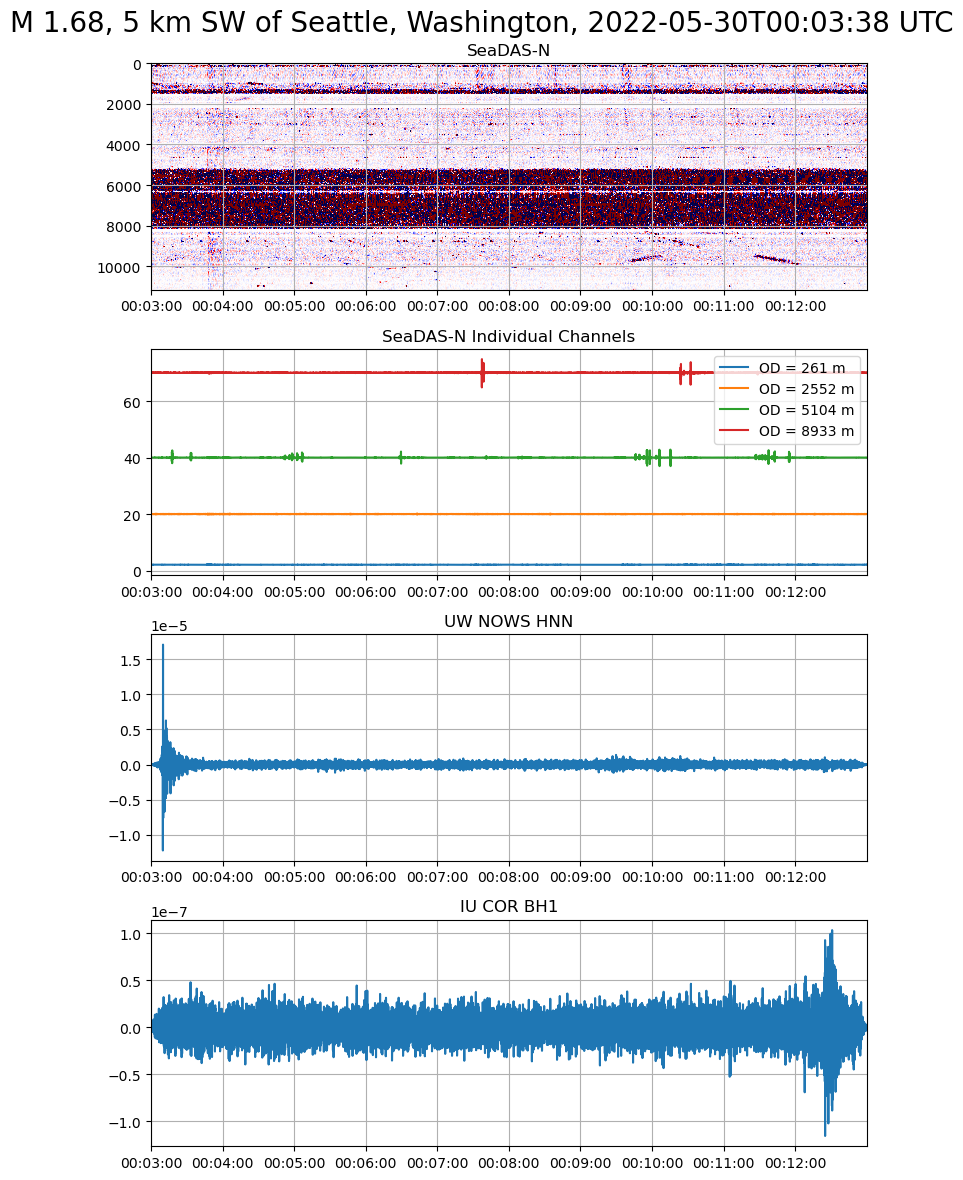

In [40]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)


stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

In [9]:
this_event.url.to_list()[0]

'https://earthquake.usgs.gov/earthquakes/eventpage/uw61835766'

In [10]:
# from tqdm import tqdm
# xc = np.zeros((2*18000-1,174))

# for i in tqdm(range(174)):
#     xc[:,i] = np.correlate( data_filt[:,30]/max(data_filt[:,30]),
#                             data_filt[:,i*10]/max(data_filt[:,i*10]),
#                             mode='full')

In [11]:
from tqdm import tqdm
xc = np.zeros((2*18000-1,174))

for i in tqdm(range(174)):
    xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
                           np.sign(data_filt[:,i*10]),
                           mode='full')

ModuleNotFoundError: No module named 'tqdm'

NameError: name 'xc' is not defined

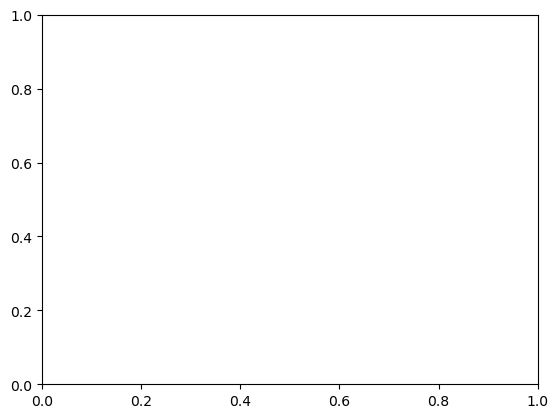

In [42]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
plt.xlim(18000-1e3,18000+1e3)
plt.show()

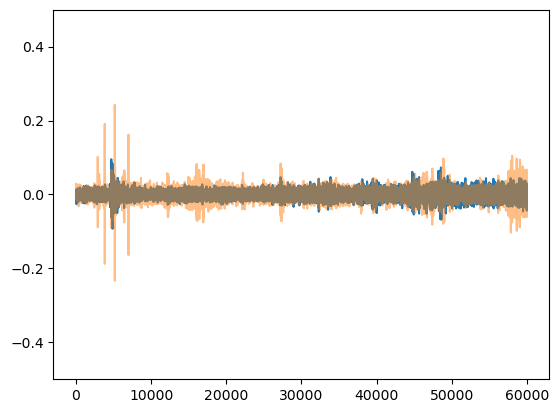

In [43]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,40])
plt.plot(data_filt[:,30],alpha=0.5)
#plt.xlim(7050,7200)
plt.ylim(-0.5,0.5)
plt.show()

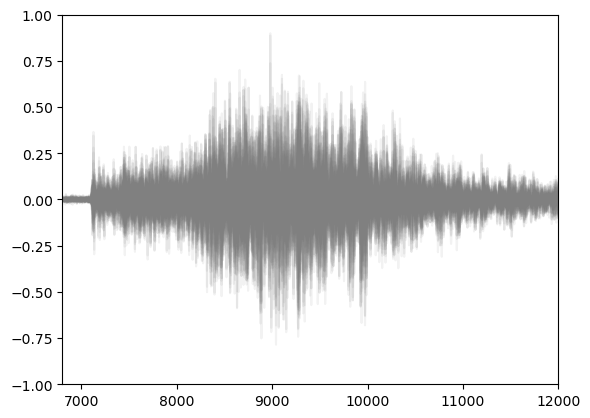

In [109]:
fig,ax=plt.subplots()

for i in data_filt.T[30:100]:
    ax.plot(i, c='grey', alpha=0.1)
plt.xlim([6800,12000])
plt.ylim([-1,1])
plt.show()

In [177]:
from scipy.fft import fft, ifft
af = fft(data_filt[:,11])
bf = fft(data_filt[:,60])
c = ifft(af * scipy.conj(bf))

time_shift = np.argmax(c)
print(time_shift)

4


/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.conj is deprecated and will be removed in SciPy 2.0.0, use numpy.conj instead
  after removing the cwd from sys.path.


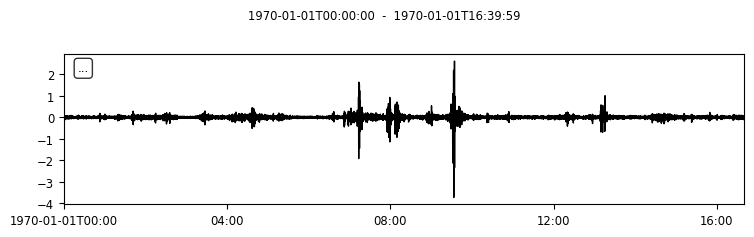

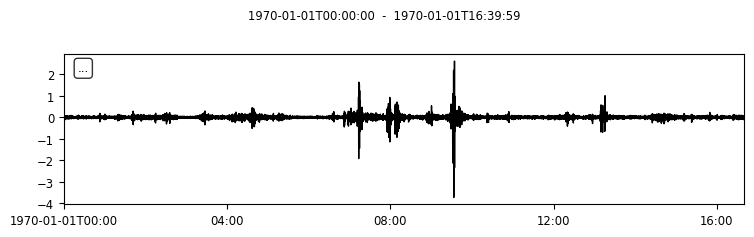

In [50]:
import obspy.core.trace 
das_trace = obspy.core.trace.Trace(data_filt[:,200])
das_trace.plot()

In [213]:
das_trace.stats['sampling_rate'] = 100.0

In [214]:
das_trace.stats.sampling_rate

100.0

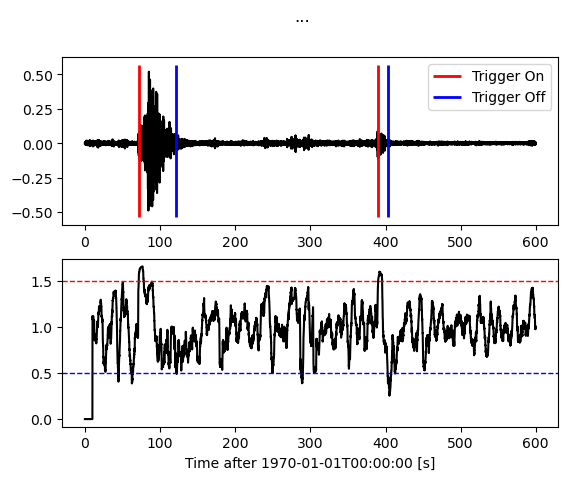

In [216]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger

df = das_trace.stats.sampling_rate
cft = classic_sta_lta(c, int(6 * df), int(10 * df))

plot_trigger(das_trace, cft, 1.5, 0.5)

In [223]:
print(cft.argmax())

7646


In [257]:
channel_picks = []
chan_number = 0

for channel in data_filt.T:
    das_trace = obspy.core.trace.Trace(channel)
    das_trace.stats['sampling_rate'] = 100.0
    df = das_trace.stats.sampling_rate
    cft = classic_sta_lta(das_trace, int(5 * df), int(10 * df))
    
    channel_picks.append( cft.argmax() / 100 )
    
    chan_number +=1

In [258]:
channel_picks

[80.43,
 599.3,
 356.74,
 426.59,
 589.55,
 89.1,
 78.04,
 359.25,
 199.42,
 397.04,
 578.76,
 599.76,
 88.41,
 599.98,
 78.17,
 89.3,
 79.74,
 80.13,
 398.18,
 139.53,
 384.88,
 438.46,
 552.05,
 577.96,
 330.52,
 292.17,
 438.43,
 285.1,
 74.98,
 76.04,
 421.32,
 76.2,
 76.2,
 76.1,
 76.33,
 75.95,
 76.49,
 76.19,
 76.07,
 76.19,
 76.18,
 75.96,
 76.07,
 75.96,
 75.98,
 75.99,
 76.0,
 76.0,
 76.15,
 76.0,
 505.73,
 87.93,
 76.13,
 76.09,
 76.0,
 75.9,
 75.9,
 75.82,
 75.69,
 75.89,
 75.7,
 75.7,
 75.77,
 75.78,
 75.99,
 76.04,
 76.03,
 76.16,
 76.01,
 76.0,
 75.93,
 75.93,
 76.16,
 75.94,
 75.65,
 76.01,
 75.66,
 75.61,
 75.65,
 75.69,
 75.68,
 75.7,
 75.88,
 76.01,
 75.94,
 75.84,
 75.95,
 75.96,
 75.96,
 75.96,
 75.96,
 76.02,
 76.09,
 75.75,
 75.76,
 75.96,
 75.96,
 75.96,
 75.95,
 75.99,
 86.14,
 76.22,
 76.03,
 75.86,
 75.96,
 75.95,
 75.97,
 76.11,
 76.11,
 76.01,
 75.96,
 75.96,
 75.83,
 75.83,
 75.84,
 75.92,
 554.62,
 76.04,
 75.79,
 75.9,
 75.9,
 75.97,
 75.97,
 75.98,
 75.

Text(0.5, 0, 'Channel Number')

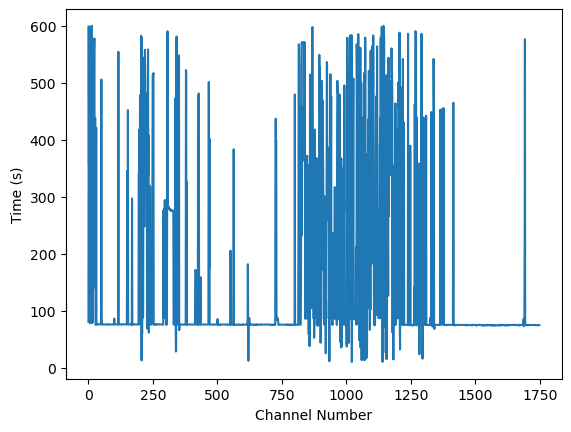

In [259]:
plt.plot(channel_picks)
#plt.ylim([7000,8000])
plt.ylabel('Time (s)')
plt.xlabel('Channel Number')

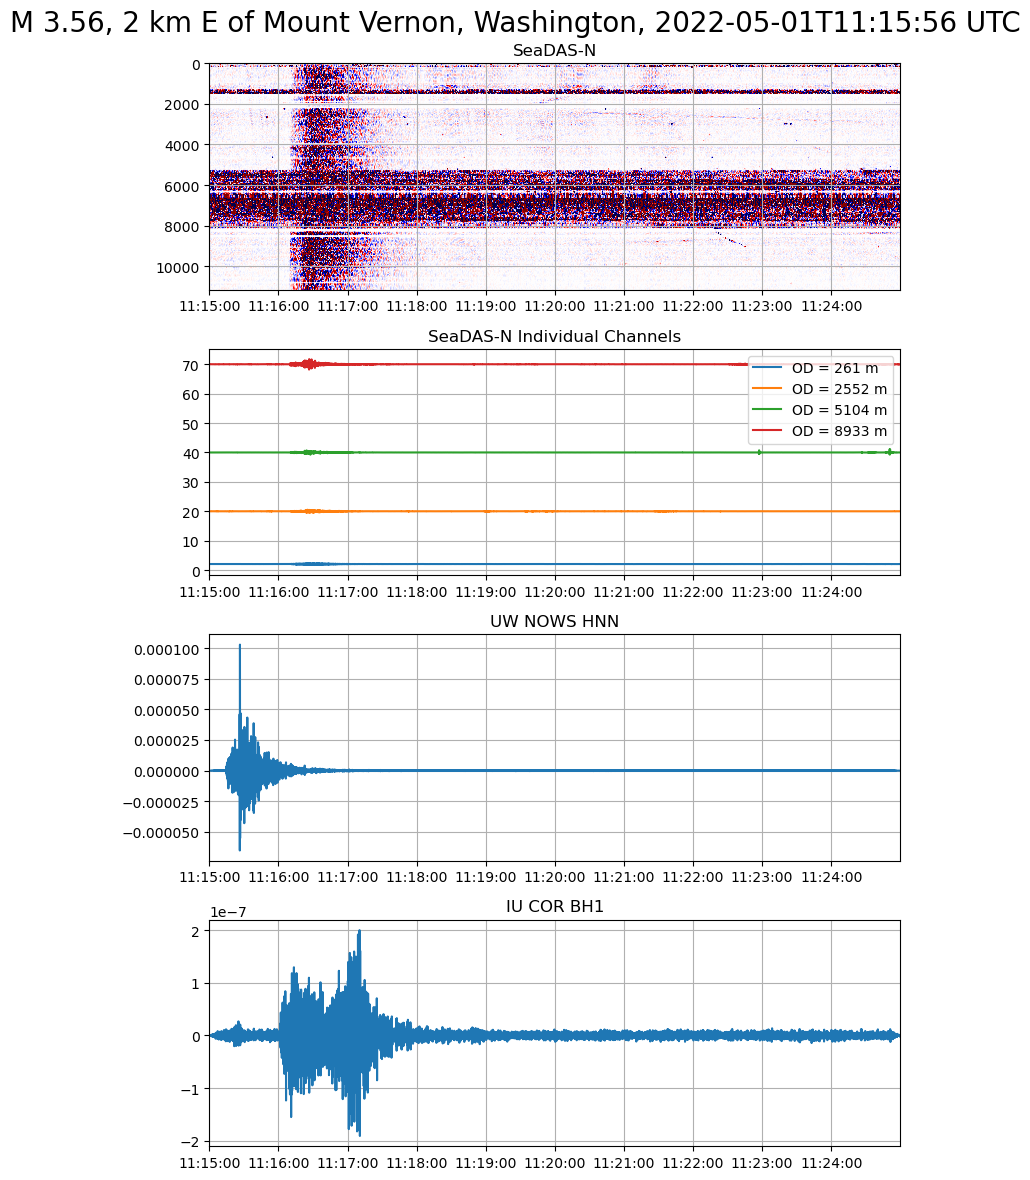

In [261]:
local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

# Routine for picking wave arrival times from lcoal events

In [304]:
#Function that returns the DAS data according to USGS earthquake events

def das_downloader(this_id, cab='seadasn'):
    this_event = event_df[event_df.id==this_id]
    t0 = this_event['time'].iloc[0]

    cable = cab
    record_length = 10 #minutes
    
    try:
        if cable == 'seadasn':
            prefix = 'seadasn'
            network_name = 'SeaDAS-N'
            if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
                datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
            else:
                datastore='/data/data7/seadasn/'

        elif cable == 'whidbey':
            prefix = 'whidbey'
            network_name='Whidbey-DAS'
            datastore = '/data/data5/Converted/'

        data,dates,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']
        
        low_cut = 2
        hi_cut = 10

        b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        data_filt = filtfilt(b,a,data,axis=0)
    
    except:
        print('No data for thhis quake!')
        data = None
        dates = None
        attrs = None
        x_max = None
        data_filt = None
    return data, dates, attrs, x_max, this_id, data_filt

In [303]:

#Load events (specify search radius)
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=30, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))

#Get list of USGS events
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)

#Create a list with the event id numbers for data download
earthquake_list = event_df['id'].values.tolist()

Returned 57 events


In [305]:
arrival_picks = {}
das_quake_attrs = {}

for i in earthquake_list:
    
    data, dates, attrs, x_max, this_id, data_filt = das_downloader(i)
    das_quake_attrs[this_id] = attrs
    if  x_max != None:
        channel_picks = []
        chan_number = 0
        for channel in data_filt.T:
            das_trace = obspy.core.trace.Trace(channel)
            das_trace.stats['sampling_rate'] = 100.0
            df = das_trace.stats.sampling_rate
            cft = classic_sta_lta(das_trace, int(5 * df), int(10 * df))

            channel_picks.append( cft.argmax() / 100 )

            chan_number +=1
    
    arrival_picks[str(i)] = channel_picks
    

/data/data7/seadasn/seadasn_2022-06-25_13-08*.h5
No data for thhis quake!
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-22*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-23*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-24*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-25*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-26*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-27*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-28*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-29*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-30*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-04-26_22-31*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-11_19-42*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-11_19-43*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-11_19-44*.h5
/da

In [332]:
arrival_times_1749 = []

for i in arrival_picks:
    if len(arrival_picks[i]) == 1749:
        print(i)
        arrival_times_1749.append(arrival_picks[i])

uw61846087
uw61850536
uw61877107
uw61884286
uw61879156
uw61888846
uw61842061
uw61890241
uw61837027
uw61824027
uw61874622
uw61884291
uw61844597
uw61847381
uw61878407
uw61864627
uw61841392
uw61876201
uw61830387
uw61828042
uw61835371
uw61837007
uw61878547
uw61841216
uw61835231
uw61881517
uw61862181
uw61868782
uw61850701
uw61827977
uw61880126
uw61836281
uw61841186


In [340]:
arrival_times_1749 = np.asarray(arrival_times_1749)

In [2]:
plt.imshow(arrival_times_1749, aspect='auto')
plt.colorbar(label = 'Arrival Time (s)')

NameError: name 'plt' is not defined

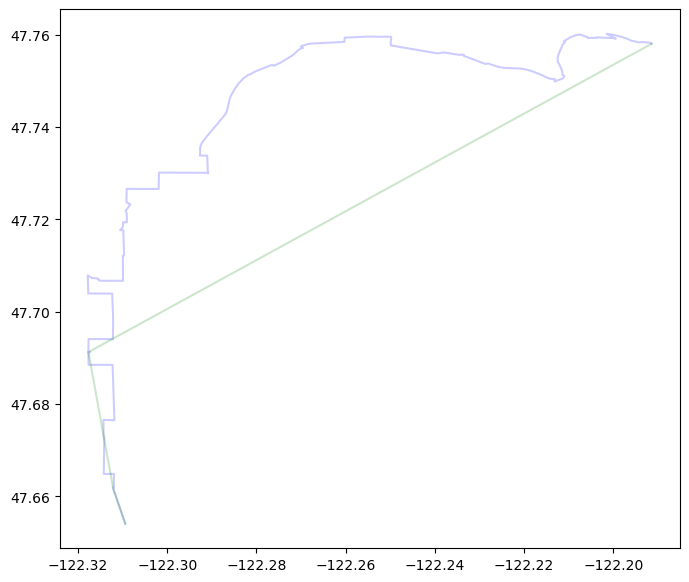

In [5]:
#Load the fiber location and calibration data
fiber_location = pd.read_csv('fiberroute.csv', header=1)
fiber_calibration = pd.read_csv('calibration.csv', header=1)

#Plot
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location['Long'], fiber_location['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration['Long'], fiber_calibration['Lat'], zorder=1, alpha= 0.2, c='g')

In [6]:
#Calculate the fiber distance between points in the fiber location file
import geopy.distance
fiber_distance = []

for index, row in fiber_location.iterrows():
    if index == 0 :
        fiber_distance.append(0)
    elif index <= len(fiber_location.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location.iloc[index-1]['Lat'], fiber_location.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance.append(distance)
        
fiber_location['Fiber Dist'] = fiber_distance

0 index = 0
index =  1
index =  2
index =  3
index =  4
index =  5
index =  6
index =  7
index =  8
index =  9
index =  10
index =  11
index =  12
index =  13
index =  14
index =  15
index =  16
index =  17
index =  18
index =  19
index =  20
index =  21
index =  22
index =  23
index =  24
index =  25
index =  26
index =  27
index =  28
index =  29
index =  30
index =  31
index =  32
index =  33
index =  34
index =  35
index =  36
index =  37
index =  38
index =  39
index =  40
index =  41
index =  42
index =  43
index =  44
index =  45
index =  46
index =  47
index =  48
index =  49
index =  50
index =  51
index =  52
index =  53
index =  54
index =  55
index =  56
index =  57
index =  58
index =  59
index =  60
index =  61
index =  62
index =  63
index =  64
index =  65
index =  66
index =  67
index =  68
index =  69
index =  70
index =  71
index =  72
index =  73
index =  74
index =  75
index =  76
index =  77
index =  78
index =  79
index =  80
index =  81
index =  82
index =  83
i

In [7]:
fiber_location

,Lat,Long,Elev,Description,Fiber Dist
0,47.654085,-122.309411,0,NaN,0.000000
1,47.661686,-122.312116,0,NaN,869.191066
2,47.661686,-122.312127,0,NaN,0.826231
3,47.661742,-122.312127,0,NaN,6.226289
4,47.661742,-122.312036,0,NaN,6.835180
...,...,...,...,...,...
206,47.758301,-122.194216,0,NaN,153.953659
207,47.758385,-122.193560,0,NaN,50.061343
208,47.758206,-122.191504,0,NaN,155.424543
209,47.757981,-122.191496,0,NaN,25.023952


In [8]:
fiber_calibration

,Lat,Long,Elev,Opt Dist,Scale Name,Scale Number,Description,State,Purpose,Scale Suffix
0,47.654085,-122.309411,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,47.661686,-122.312116,0.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
2,47.691258,-122.317682,0.0,6400.0,NaN,NaN,NaN,NaN,NaN,NaN
3,47.757981,-122.191467,0.0,29043.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
opt_dis_merge = []

for index_fib, row_fib in fiber_location.iterrows():
    l = []
    for index_cal, row_cal in fiber_calibration.iterrows():
        if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
            l.append(row_cal['Opt Dist'])
        else:
            pass
    if l:
        opt_dis_merge.append(l[0])
    else:
        opt_dis_merge.append(np.nan)

In [23]:
fiber_location['Opt Dist'] = opt_dis_merge
dis_interp = fiber_location['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
fiber_location['Opt Dist Interp'] = dis_interp

fiber_location

,Lat,Long,Elev,Description,Fiber Dist,Opt Dist,Opt Dist Interp
0,47.654085,-122.309411,0,NaN,0.000000,1.0,1.000000
1,47.661686,-122.312116,0,NaN,869.191066,1500.0,1500.000000
2,47.661686,-122.312127,0,NaN,0.826231,NaN,1713.043478
3,47.661742,-122.312127,0,NaN,6.226289,NaN,1926.086957
4,47.661742,-122.312036,0,NaN,6.835180,NaN,2139.130435
...,...,...,...,...,...,...,...
206,47.758301,-122.194216,0,NaN,153.953659,NaN,28553.421622
207,47.758385,-122.193560,0,NaN,50.061343,NaN,28675.816216
208,47.758206,-122.191504,0,NaN,155.424543,NaN,28798.210811
209,47.757981,-122.191496,0,NaN,25.023952,NaN,28920.605405
